Dimensões: (3683, 18)
   course_id                                       course_title                                                url  \
0    1070968                 Ultimate Investment Banking Course  https://www.udemy.com/ultimate-investment-bank...   
1    1113822  Complete GST Course & Certification - Grow You...      https://www.udemy.com/goods-and-services-tax/   
2    1006314  Financial Modeling for Business Analysts and C...  https://www.udemy.com/financial-modeling-for-b...   
3    1210588  Beginner to Pro - Financial Analysis in Excel ...  https://www.udemy.com/complete-excel-finance-c...   
4    1011058       How To Maximize Your Profits Trading Options  https://www.udemy.com/how-to-maximize-your-pro...   
5     192870  Trading Penny Stocks: A Guide for All Levels I...  https://www.udemy.com/trading-penny-stocks-a-g...   
6     739964  Investing And Trading For Beginners: Mastering...  https://www.udemy.com/investing-and-trading-fo...   
7     403100  Trading Stock Chart 

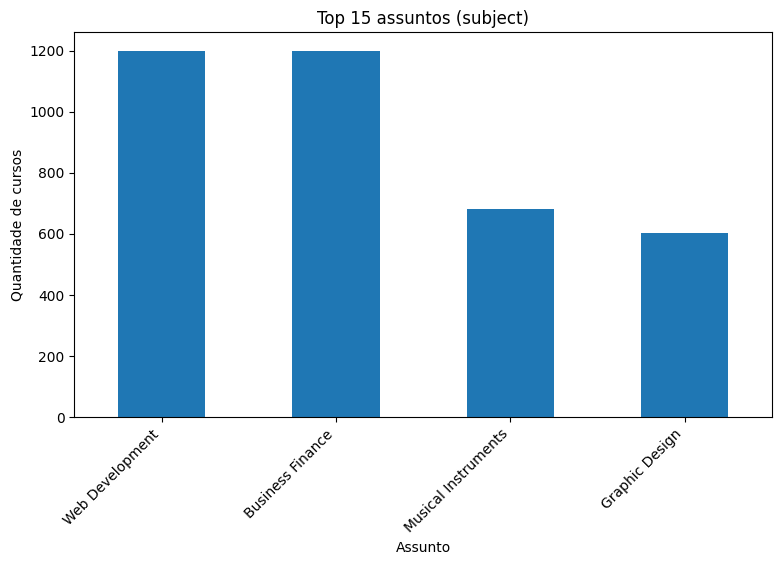

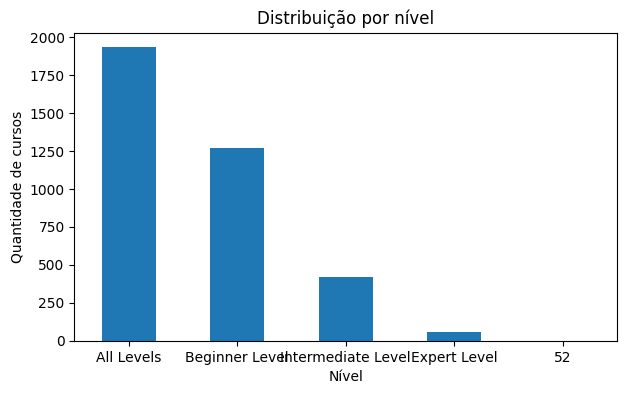

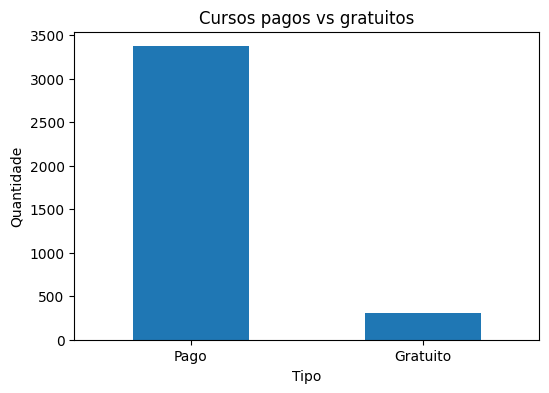

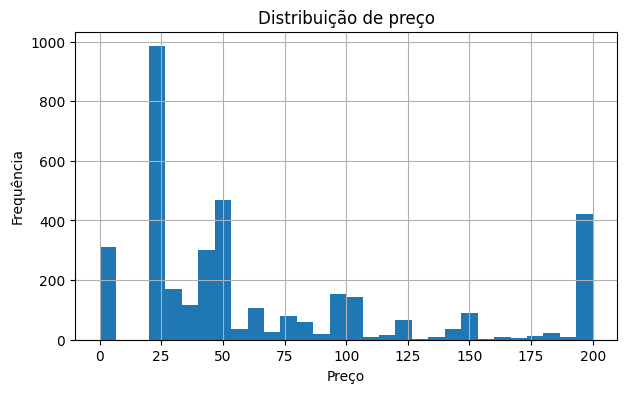

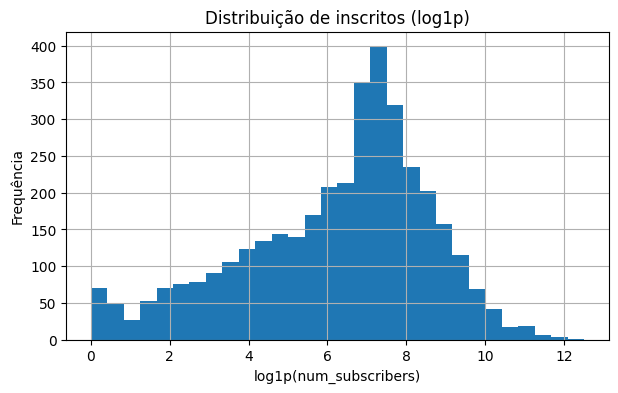

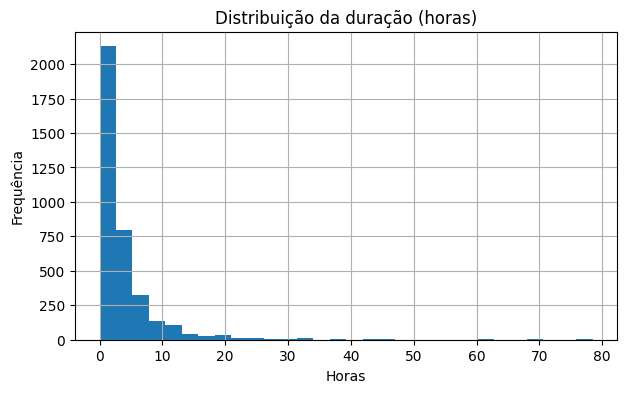

      course_id                                       course_title              subject           level  price  \
2832      41295               Learn HTML5 Programming From Scratch      Web Development      All Levels      0   
3037      59014                     Coding for Entrepreneurs Basic      Web Development  Beginner Level      0   
3235     625204                         The Web Developer Bootcamp      Web Development      All Levels    200   
2788     173548  Build Your First Website in 1 Week with HTML5 ...      Web Development  Beginner Level      0   
3237     764164              The Complete Web Developer Course 2.0      Web Development      All Levels    200   
1900      19421              Free Beginner Electric Guitar Lessons  Musical Instruments  Beginner Level      0   
2594     473160  Web Design for Web Developers: Build Beautiful...      Web Development      All Levels      0   
2624      94430             Learn Javascript & JQuery From Scratch      Web Development 

In [2]:
# ============================
# EDA – Udemy Course Dataset (Entrega 2)
# ============================
# Objetivo: analisar a base original e produzir um arquivo limpo ao final,
# pronto para a próxima etapa do projeto (tratamento → técnica → PoC).

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 120)

# ============================
# 1) Carregamento do dataset
# ============================
PATH_MAIN = "/Users/iloop/Desktop/Projeto/udemy_course_data.csv"   # caminho absoluto corrigido
df = pd.read_csv(PATH_MAIN)

print("Dimensões:", df.shape)
print(df.head(10))

# ============================
# 2) Estrutura: colunas, tipos e amostra
# ============================
print("Colunas:\n", list(df.columns))
print("\nTipos de dados:\n", df.dtypes)
print(df.sample(10))

# ============================
# 3) Nulos e duplicados
# ============================
nulls = df.isnull().sum().sort_values(ascending=False)
print("Nulos por coluna (ordem desc):")
print(nulls)

dup_id = df.duplicated(subset=["course_id"]).sum() if "course_id" in df.columns else None
dup_title = df.duplicated(subset=["course_title"]).sum() if "course_title" in df.columns else None
print({"duplicados_por_course_id": dup_id, "duplicados_por_course_title": dup_title})

# =====================================================
# 4) Engenharia leve: duração (horas), pago/gratuito, datas
# =====================================================
def parse_hours(x: str):
    if pd.isna(x):
        return np.nan
    s = str(x).strip().lower()
    if "hour" in s:
        try:
            return float(s.split()[0])
        except:
            return np.nan
    if "min" in s:
        try:
            return float(s.split()[0]) / 60.0
        except:
            return np.nan
    try:
        return float(s)
    except:
        return np.nan

if "content_duration" in df.columns:
    df["content_duration_hours"] = df["content_duration"].apply(parse_hours)

# rótulo de pago/gratuito
if "is_paid" in df.columns:
    tmp = df["is_paid"].astype(str).str.lower()
    mapper = {"true": True, "false": False, "paid": True, "free": False}
    paid_bool = tmp.map(lambda v: mapper.get(v, np.nan))
    if paid_bool.isna().mean() > 0.4 and "price" in df.columns:
        paid_bool = pd.to_numeric(df["price"], errors="coerce").fillna(0) > 0
    df["paid_label"] = np.where(paid_bool, "Pago", "Gratuito")
elif "price" in df.columns:
    df["paid_label"] = np.where(pd.to_numeric(df["price"], errors="coerce").fillna(0) > 0, "Pago", "Gratuito")

# datas
if "published_timestamp" in df.columns:
    df["published_dt"] = pd.to_datetime(df["published_timestamp"], errors="coerce")
elif "published_date" in df.columns:
    df["published_dt"] = pd.to_datetime(df["published_date"] + " " + df.get("published_time", ""), errors="coerce")
else:
    df["published_dt"] = pd.NaT

df["year"] = df["published_dt"].dt.year
df["month"] = df["published_dt"].dt.month
df["day"] = df["published_dt"].dt.day

print(df.head())

# ============================
# 5) Resumo estatístico de numéricos
# ============================
num_cols = [c for c in ["price","num_subscribers","num_reviews","num_lectures","profit","content_duration_hours","year","month","day"] if c in df.columns]
print(df[num_cols].describe().T)

# ============================
# 6) Distribuição por assunto (subject)
# ============================
if "subject" in df.columns:
    plt.figure(figsize=(9,5))
    df["subject"].value_counts().head(15).plot(kind="bar")
    plt.title("Top 15 assuntos (subject)")
    plt.xlabel("Assunto")
    plt.ylabel("Quantidade de cursos")
    plt.xticks(rotation=45, ha="right")
    plt.show()

# ============================
# 7) Distribuição por nível (level)
# ============================
if "level" in df.columns:
    plt.figure(figsize=(7,4))
    df["level"].fillna("Unknown").value_counts().plot(kind="bar")
    plt.title("Distribuição por nível")
    plt.xlabel("Nível")
    plt.ylabel("Quantidade de cursos")
    plt.xticks(rotation=0)
    plt.show()

# ============================
# 8) Pagos vs Gratuitos
# ============================
if "paid_label" in df.columns:
    plt.figure(figsize=(6,4))
    df["paid_label"].value_counts().plot(kind="bar")
    plt.title("Cursos pagos vs gratuitos")
    plt.xlabel("Tipo")
    plt.ylabel("Quantidade")
    plt.xticks(rotation=0)
    plt.show()

# ============================
# 9) Distribuição de preço
# ============================
if "price" in df.columns:
    plt.figure(figsize=(7,4))
    pd.to_numeric(df["price"], errors="coerce").dropna().hist(bins=30)
    plt.title("Distribuição de preço")
    plt.xlabel("Preço")
    plt.ylabel("Frequência")
    plt.show()

# ============================
# 10) Distribuição de inscritos (log1p)
# ============================
if "num_subscribers" in df.columns:
    plt.figure(figsize=(7,4))
    np.log1p(pd.to_numeric(df["num_subscribers"], errors="coerce")).dropna().hist(bins=30)
    plt.title("Distribuição de inscritos (log1p)")
    plt.xlabel("log1p(num_subscribers)")
    plt.ylabel("Frequência")
    plt.show()

# ============================
# 11) Distribuição da duração (horas)
# ============================
if "content_duration_hours" in df.columns:
    plt.figure(figsize=(7,4))
    pd.to_numeric(df["content_duration_hours"], errors="coerce").dropna().hist(bins=30)
    plt.title("Distribuição da duração (horas)")
    plt.xlabel("Horas")
    plt.ylabel("Frequência")
    plt.show()

# ============================
# 12) Top 10 por número de inscritos
# ============================
cols_show = [c for c in ["course_id","course_title","subject","level","price","num_subscribers"] if c in df.columns]
if "num_subscribers" in df.columns:
    top10 = df.sort_values("num_subscribers", ascending=False)[cols_show].head(10)
    print(top10)

# ============================
# 13) Correlação entre variáveis numéricas
# ============================
if len(num_cols) > 0:
    corr = df[num_cols].corr(numeric_only=True)
    print(corr)

# =====================================================
# 14) Limpeza e exportação do dataset
# =====================================================
clean = df.copy()

# Remoção de duplicatas
if "course_id" in clean.columns:
    clean = clean.drop_duplicates(subset=["course_id"])
if "course_title" in clean.columns:
    clean = clean.drop_duplicates(subset=["course_title"])

# Conversões numéricas
for col in ["price","num_subscribers","num_reviews","num_lectures","profit","content_duration_hours","year","month","day"]:
    if col in clean.columns:
        clean[col] = pd.to_numeric(clean[col], errors="coerce")

# Normalização leve (versões auxiliares)
for col in ["level","subject"]:
    if col in clean.columns:
        clean[col + "_norm"] = clean[col].astype(str).str.strip().str.lower()

# Exporta CSV limpo para a pasta do projeto no Mac
CLEAN_CSV = "/Users/iloop/Desktop/Projeto/udemy_courses_clean.csv"
clean.to_csv(CLEAN_CSV, index=False)

print("Arquivo limpo gerado em:", CLEAN_CSV)
print(clean.head(10))
